### TITLE : Technical Analysis Using Python
<p> Author : BRYAN LIM YUQIANG </p> 
<p> Contact me : </p>
<li>Bryanlimyuqiang@gmail.com</li>
<li><a href = "https://www.linkedin.com/in/bryanlimyuqiang/">Linkedin </a></li> 
<li><a href = "https://www.etoro.com/people/bryanlimyuqiang"> Follow my trading journey </a></li>

### Covers: 
<ol> 
    <li> MACD </li>
    <li> BB & ATR </li>
    <li> RSI </li>
    <li> ADX </li>
    <li> OBV </li>
    <li> Slope- OLS </li>
    <li> Renko  </li>
    <li> Spare me the math: TA-LIB </li>
</ol> 
    

In [42]:
# import necessary libraries
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr 
import datetime 
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [43]:
#Set-up Historical Data for required stocks
ticker = 'MSFT'
#get_data_yahoo(ticker, start, end) We use 5 years date in this case
ohlc = pdr.get_data_yahoo(ticker,datetime.date.today() - datetime.timedelta(1825), datetime.date.today())
#MACD SET-UP (12,26)
df = ohlc.copy()


## 1. Moving Average Convergence Divergence (MACD)

<img src ="./images/macd-trading.png" alt = "macd-trading.png" width = "700"/>

<img src="./images/MACD.jpg" width = "700"/>

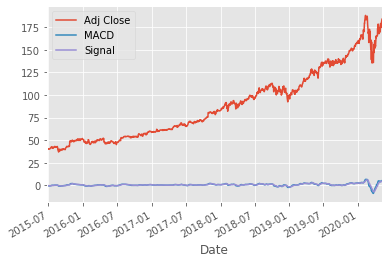

In [3]:

def MACD(DF,a,b,c):
    df =DF.copy()
        # Calculation to get MACD and Signal
    df['MA_Fast'] = df['Adj Close'].ewm(span =a, min_periods=a).mean()
    df['MA_Slow'] = df['Adj Close'].ewm(span = b, min_periods =b).mean()
    df['MACD'] = df['MA_Fast'] - df['MA_Slow']

    # Calculation to get Signal
    df['Signal'] = df['MACD'].ewm(span=c, min_periods =c).mean()

    # Clean up NaN Values
    df.dropna(inplace = True)

    return df



df_MACD = MACD(ohlc, 12,26,9)
#Data visualisation
# 5 =  Adj Close, 8 = MACD, 9 = Signal 
df_MACD.iloc[:, [5,8,9]].plot()

## 2. Bolinger Bands and Average True Range (ATR) 

<img src = "./images/BBATR.JPG" alt = "BBATR.jpg" width ="700" />

### Bolinger Bands 

<img src = "./images/bb.png" alt = 'bb.png' width = "700"/>

In [4]:
def BollBnd(DF,n):
    #Function to calculate BB 
    df = DF.copy()
    df['MA'] = df['Adj Close'].rolling(n).mean()
    df['BB_up']  = df['MA'] + 2*df['MA'].rolling(n).std()
    df['BB_down'] = df['MA'] - 2*df['MA'].rolling(n).std()
    df['BB_range'] = df['BB_up'] - df['BB_down']
    df.dropna(inplace =True)
    return df

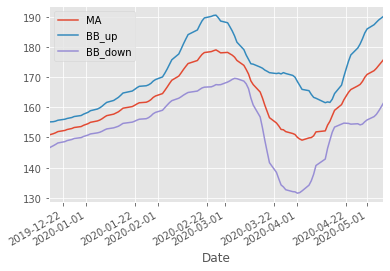

In [5]:
#-4 = MA , -3 = BB_up, -2 = BB_down
BollBnd(ohlc, 20).iloc[-100:,[-4,-3,-2]].plot()

### Average True Range (ATR)

<img src = "./images/ATR.png" alt= 'ATR.png' />

In [6]:
#We will be taking in the TSLA ticker dataframe as declared above

def ATR(DF,n):
    # function to calculate True Range and Average True Range
    df = DF.copy()
    df['H-L'] = abs(df['High']-df['Low']) #Present High - Present Low
    df['H-PC'] = abs(df['High']- df['Adj Close'].shift(1)) #Present High - Previous Close
    df['L-PC'] =abs(df['Low']- df['Adj Close'].shift(1)) #Present Low - Previous Close
    df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1,skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span= n, adjust =False, min_period=n).mean() #<- optional to use exponential mean
    df2 = df.drop(['H-L', 'H-PC', 'L-PC'], axis =1 )
    return df2

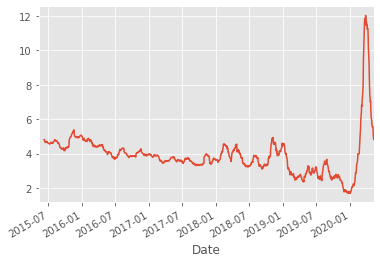

In [7]:
ATR(ohlc, 20)['ATR'].plot()

## 3. Relative Strength Indicator (RSI)

<img src="./images/RSI.jpg" alt ="RSI.jpg" width ="700"/>

<img src="./images/rsi.png" alt ="rsi.png"/>

In [8]:
def RSI(DF,n):
    #function to calculate RSI
    df = DF.copy()
    
    #step 1. Find gain or loss before we can find average gain/loss!
    df['delta'] = df['Adj Close'] - df['Adj Close'].shift(1)
    df['gain'] = np.where(df['delta']>=0, df['delta'],0) # we will only store values to df['gain'] when delta = +ve, else 0
    df['loss'] = np.where(df['delta']<0, abs(df['delta']) ,0) # same for df['loss']
    avg_gain = []
    avg_loss = []
    gain = df['gain'].tolist()
    loss = df['loss'].tolist()
    
    # refer to step 2 of formula for this portion
    for i in range(len(df)):
        if i < n :
            
            # we set to NaN as there is no value in getting the mean of values if it is less than our predefined periods
            avg_gain.append(np.NaN)
            avg_loss.append(np.NaN)
            
        elif i == n:
            avg_gain.append(df['gain'].rolling(n).mean().tolist()[n])
            avg_loss.append(df['loss'].rolling(n).mean().tolist()[n])
        
        elif i > n: 
            avg_gain.append(((n-1)*avg_gain[i-1] + gain[i])/n)
            avg_loss.append(((n-1)*avg_loss[i-1] + loss[i])/n)
            
    df['avg_gain'] = np.array(avg_gain)
    df['avg_loss'] = np.array(avg_loss)
    df['RS'] = df['avg_gain'] / df['avg_loss'] # relative strength in ratio +ve means more gain than loss vice versa
    df['RSI'] = 100 - (100/(1+df['RS']))
    
    return df['RSI']

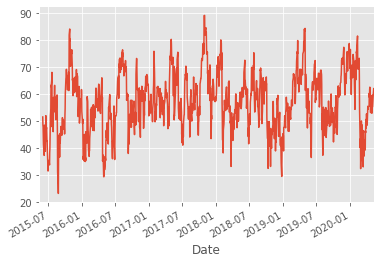

In [9]:
RSI(ohlc, 14).plot()

## 4. Average Directional Index (ADX)

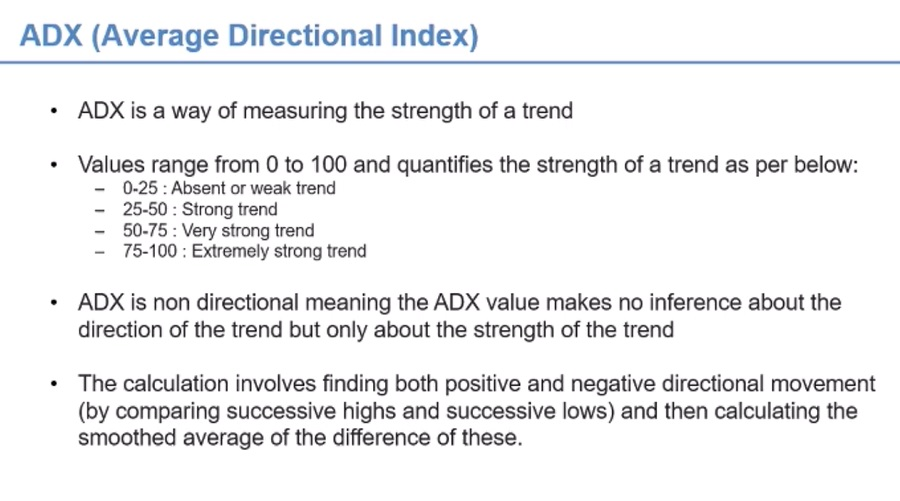

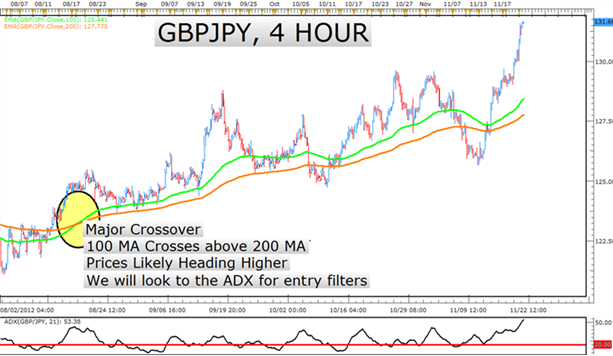

In [11]:
# WE WILL NEED THE ATR FUNCTION AS DEFINED ABOVE IN OUR CALCULATION FOR ADX
# REMEMBER ADX IS A DIRECTIONAL INDICATOR BUT A STRENGTH OF THE CURRENT DIRECTION THE INSTRUMENT IS AT

def ADX(DF,n):
    # function to calculate ADX
    df2 = DF.copy()
    df2['TR'] = ATR(df2,n)['TR'] #the period parameter of ATR function does not matter because period does not influence TR calculation
    #DMplus = upside
    df2['DMplus']=np.where((df2['High']-df2['High'].shift(1))>(df2['Low'].shift(1)-df2['Low']),df2['High']-df2['High'].shift(1),0)
    df2['DMplus']=np.where(df2['DMplus']<0,0,df2['DMplus'])
    #DMminus = downside
    df2['DMminus']=np.where((df2['Low'].shift(1)-df2['Low'])>(df2['High']-df2['High'].shift(1)),df2['Low'].shift(1)-df2['Low'],0)
    df2['DMminus']=np.where(df2['DMminus']<0,0,df2['DMminus'])
    TRn = []
    DMplusN = []
    DMminusN = []
    
    TR = df2['TR'].tolist()
    DMplus = df2['DMplus'].tolist()
    DMminus = df2['DMminus'].tolist()
    
    
    for i in range(len(df2)):
        if i < n:
            TRn.append(np.NaN)
            DMplusN.append(np.NaN)
            DMminusN.append(np.NaN)
        elif i == n:
            TRn.append(df2['TR'].rolling(n).sum().tolist()[n])
            DMplusN.append(df2['DMplus'].rolling(n).sum().tolist()[n])
            DMminusN.append(df2['DMminus'].rolling(n).sum().tolist()[n])
        elif i > n:
            TRn.append(TRn[i-1] - (TRn[i-1]/n) + TR[i])
            DMplusN.append(DMplusN[i-1] - (DMplusN[i-1]/n) + DMplus[i])
            DMminusN.append(DMminusN[i-1] - (DMminusN[i-1]/n) + DMminus[i])
            
    df2['TRn'] = np.array(TRn)
    df2['DMplusN'] = np.array(DMplusN)
    df2['DMminusN'] = np.array(DMminusN)
    df2['DIplusN']=100*(df2['DMplusN']/df2['TRn']) #Directional Indicator +
    df2['DIminusN']=100*(df2['DMminusN']/df2['TRn']) #Directional Indicator - 
    df2['DIdiff']=abs(df2['DIplusN']-df2['DIminusN'])
    df2['DIsum']=df2['DIplusN']+df2['DIminusN']
    df2['DX']=100*(df2['DIdiff']/df2['DIsum'])
    
    ADX = []
    DX = df2['DX'].tolist()
    for j in range(len(df2)):
        if j < 2*n-1:
            ADX.append(np.NaN)
        elif j == 2*n-1:
            ADX.append(df2['DX'][j-n+1:j+1].mean())
        elif j > 2*n-1:
            ADX.append(((n-1)*ADX[j-1] + DX[j])/n)
    df2['ADX']=np.array(ADX)
    return df2['ADX']

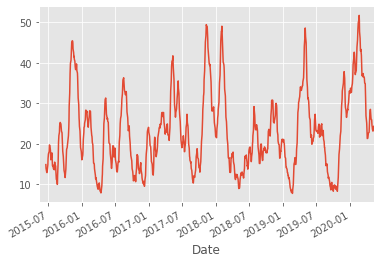

In [13]:
ADX(ohlc ,14).plot()

## 5. On Balance Volume (OBV)

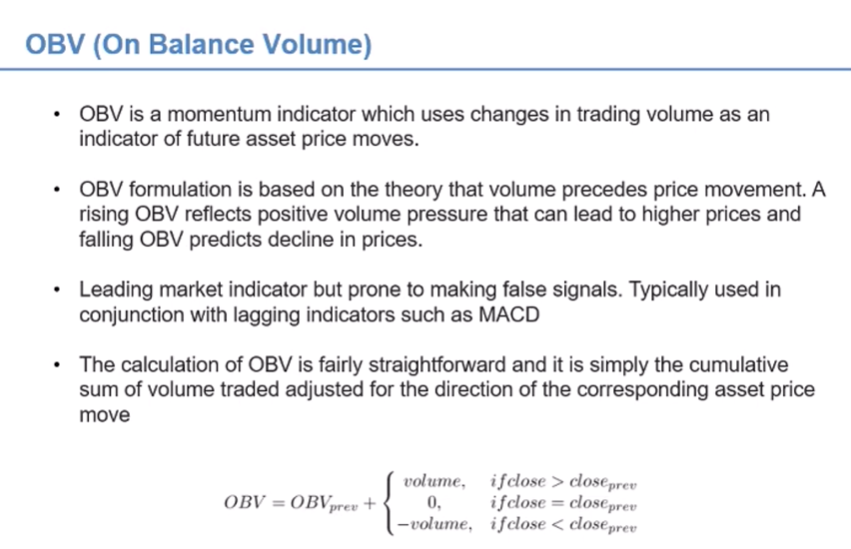

It will be important to note here that while OBV is a leading indicator, it is alos prone to generating false signals. It is usually used with other frequent indicators above rather than stand-alone. OBV's emphasis is on volume and price direction rather than price alone.

In [44]:
def OBV(DF):
    #function to calculate On Balance Volume (OBV) 
    df = DF.copy()
    df['daily_ret'] = df['Adj Close'].pct_change()
    df['direction']  = np.where(df['daily_ret']>=0, 1, -1)
    df['direction'][0] = 0 
    df['vol_adj'] =  df['Volume'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

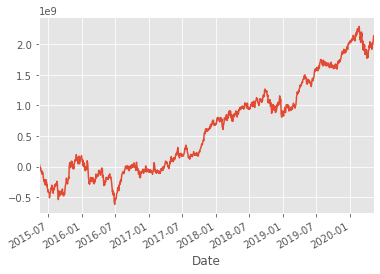

In [46]:
OBV(ohlc).plot();

## 6. Slope in a chart (Degree of Linear Regression)

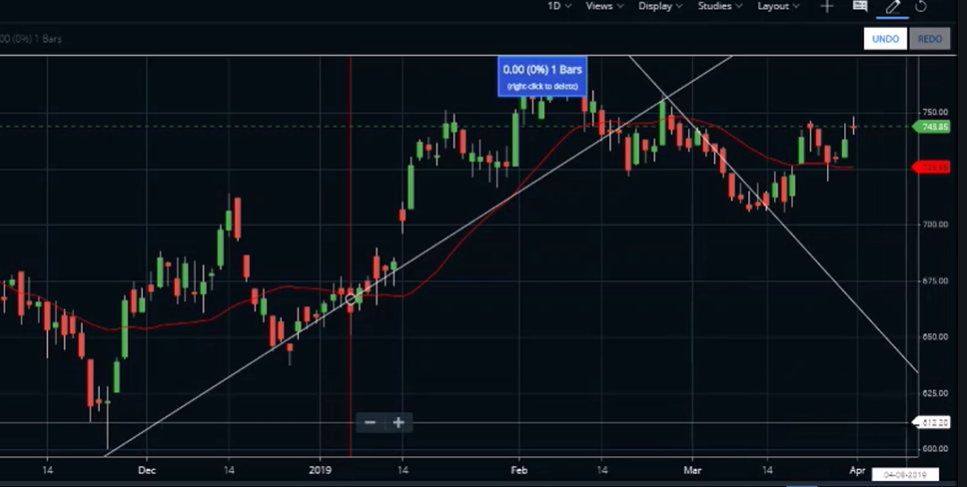

In [17]:
import statsmodels.api as sm

In [19]:
ser = ohlc['Adj Close']
n = 5  # n here refers to the number of consecutive data points
def slope(ser,n):
    # function to caculate the slope of n consecutive points on a plot
    slopes = [i*0 for i in range(n-1)]
    for i in range(n, len(ser)+1):
        y = ser[i-n:i] # first 5 values etc...
        x = np.array(range(n))
        
        # Gradient
        y_scaled = (y-y.min())/(y.max()-y.min())
        x_scaled = (x - x.min())/(x.max()-x.min())
        
        # c , y = mx +c , if without (y = mx)
        x_scaled = sm.add_constant(x_scaled) 
        
        #fit to OLS
        model = sm.OLS(y_scaled, x_scaled)
        
        # Linear Regression
        results = model.fit()
        #results.summary()
        slopes.append(results.params[-1])
    slope_angle =(np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

In [26]:
df['slope'] = slope2(ser, n)

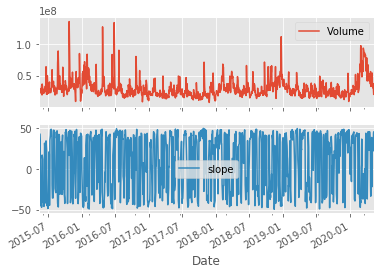

In [27]:
df.iloc[:,[4,6]].plot(subplots= True, layout = (2,1));

## 7. Renko Chart

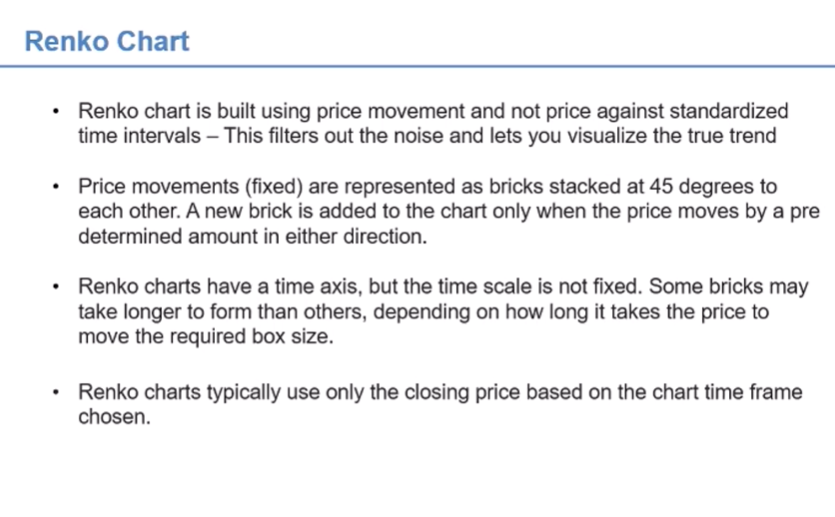

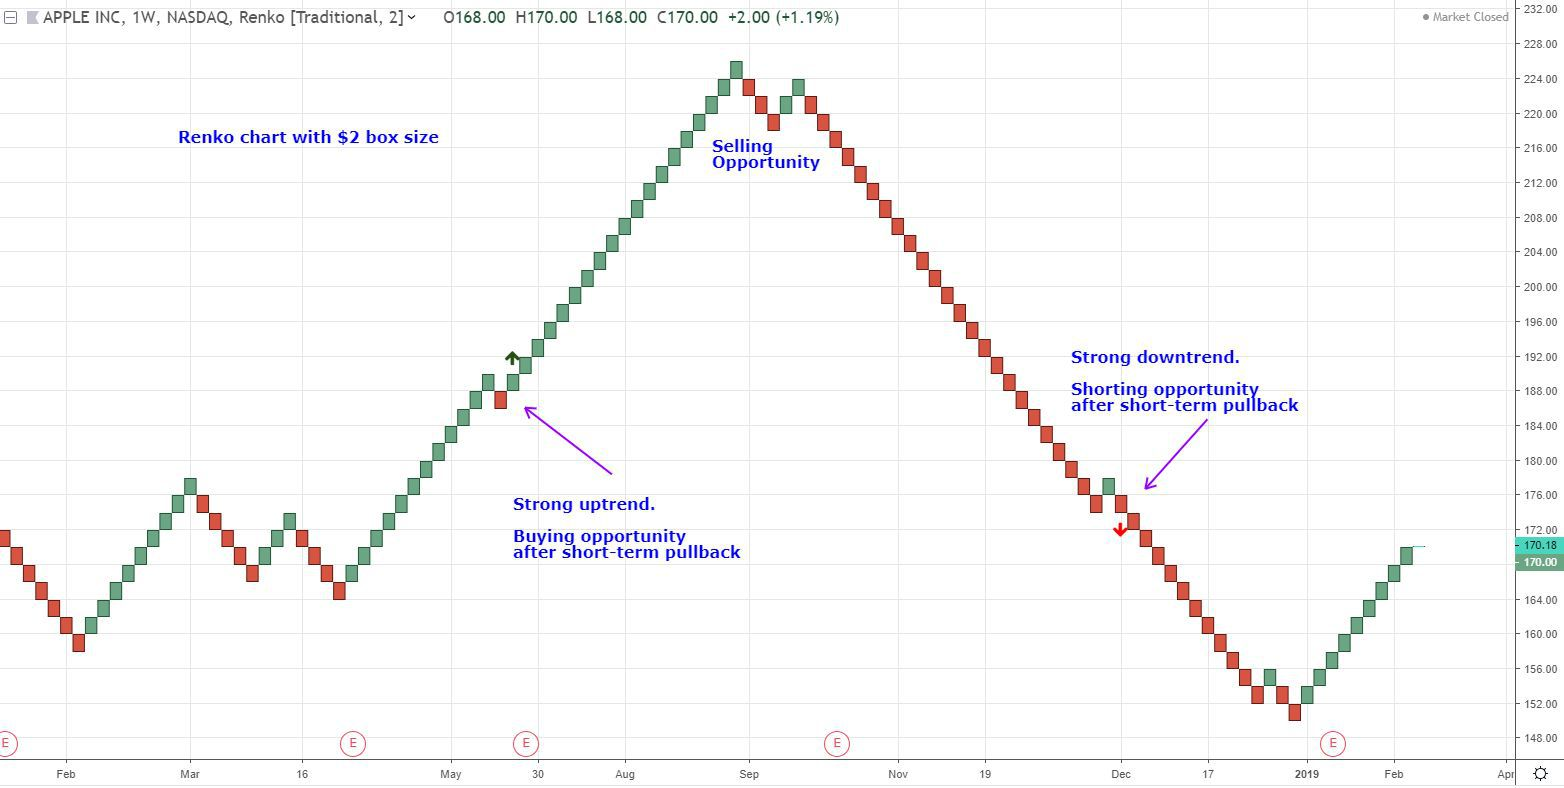

In [36]:
#pip install stocktrends 
#to implement renko
from stocktrends import Renko 

In [39]:
def renko_DF(DF):
    #function to convert ohlc data into renko bricks 
    df = DF.copy()
    # We will need to convert the columns list to what the Renko Library requires
    df.reset_index(inplace=True)
    df = df.iloc[:,[0,1,2,3,5,6]]
    df.rename(columns = {"Date" : "date", "High" : "high","Low" : "low", "Open" : "open","Adj Close" : "close", "Volume" : "volume"}, inplace = True)
    
    df2 = Renko(df)
    df2.brick_size = round(ATR(DF,120)["ATR"][-1],0)
    #renko_df = df2.get_bricks() #if get_bricks() does not work try using get_ohlc_data() instead
    renko_df = df2.get_ohlc_data()
    return renko_df

In [41]:
renko_DF(ohlc).head()

,date,open,high,low,close,uptrend
0,2015-05-11,35.0,40.0,35.0,40.0,True
1,2015-10-23,40.0,45.0,40.0,45.0,True
2,2015-11-06,45.0,50.0,45.0,50.0,True
3,2016-10-21,50.0,55.0,50.0,55.0,True
4,2016-12-19,55.0,60.0,55.0,60.0,True


### Wow....................... that's a lot of code and math.... is there any library to give me an immediate answer?

## 8. CHECK OUT TALIB 
TA-LIB Python Wrapper  Github Page: https://mrjbq7.github.io/ta-lib/ <br> 
Discussion on installation problems : https://github.com/mrjbq7/ta-lib/issues/127 <br>
Command to install TA-lib for newer versions of Python : pip install -i https://pypi.anaconda.org/masdeseiscaracteres/simple ta-lib <br>
Good website on chart patterns: http://thepatternsite.com  *<- PLEASE READ! ITS LIKE A FENGSHUI MASTER* <br>

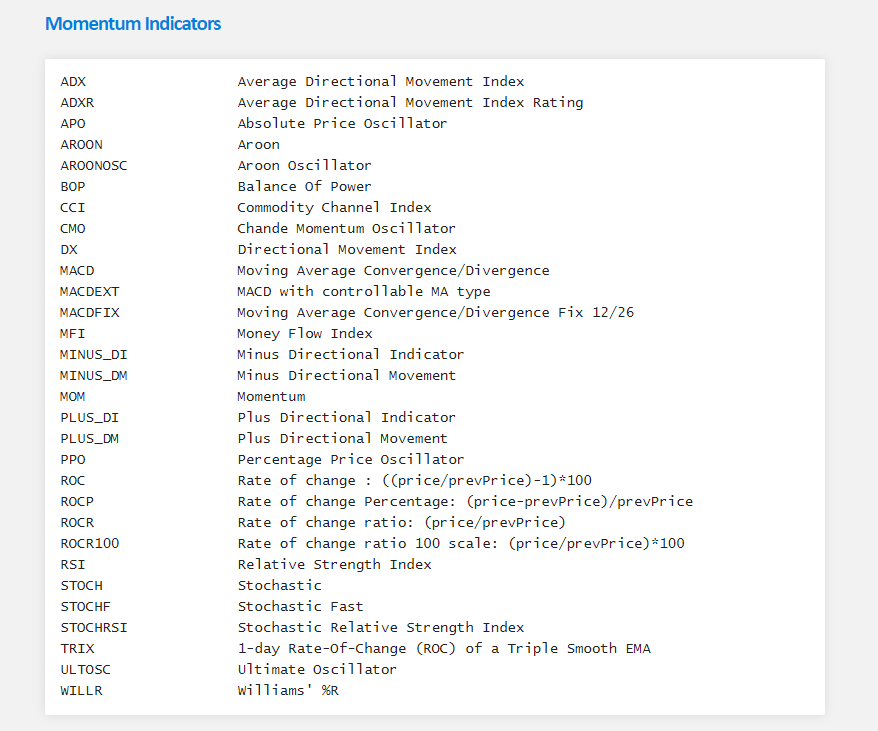

### Even patterns.. 

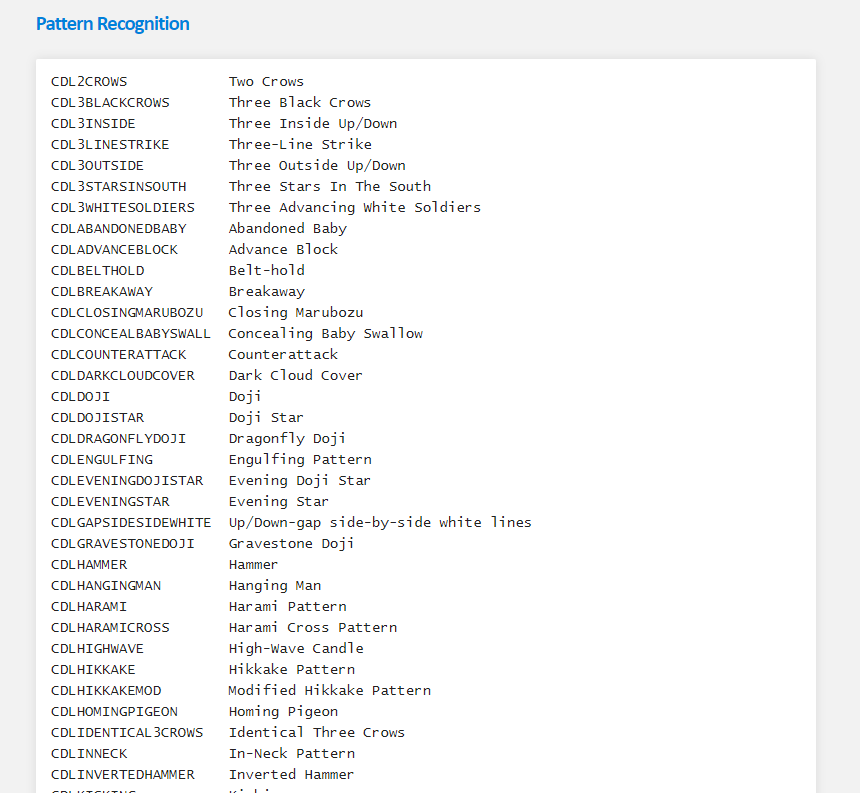

In [54]:
import talib
import copy
from alpha_vantage.timeseries import TimeSeries 

tickers = ['MSFT','AAPL', 'FB', 'AMZN']
ohlc_tech = {}
YOUR_API_KEY = "C:\\Users\\Gigabyte\\Desktop\\quant-trading-python-bot\\AlphaVantage_API.txt"
ts = TimeSeries(key = open(YOUR_API_KEY, 'r').read(), output_format = 'pandas')

attempt = 0 # initialising passthrough variable (to bypass alpha_v limit call)
drop = [] # initialise list to store tickers whose close price was successfully extracted

while len(tickers)!= 0 and attempt <= 100: #This is setup to bypass api limit calls for AV
    tickers = [j for j in tickers if j not in drop]
    for i in range(len(tickers)):
        try:
            ohlc_tech[tickers[i]] = ts.get_daily(symbol=tickers[i], outputsize = 'full')[0]
            ohlc_tech[tickers[i]].columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
            drop.append(tickers[i])
        except:
            print(tickers[i], ":failed to fetch data.. retrying")
            continue 
    attempt +=1 
    
tickers = ohlc_tech.keys()
ohlc_dict = copy.deepcopy(ohlc_tech) #copy setup to reduce chances of us ruining the dataset and having the need to run again

In [56]:
#PATTERN RECOGNITION 
# E.G CDL3INSIDE - THREE Inside Up/Down    CDL3INSIDE(open, high, low, close) <= must be in numpy array

for ticker in tickers:
    ohlc_dict[ticker]['3I'] = talib.CDL3INSIDE(ohlc_dict[ticker]['Open'],
                                              ohlc_dict[ticker]['High'],
                                              ohlc_dict[ticker]['Low'],
                                              ohlc_dict[ticker]['Adj Close'])

In [63]:
ohlc_dict['AAPL'][ohlc_dict['AAPL']['3I']> 0] 
# THESE ARE THE DATA POINTS WHERE CDL3INSIDE detected a pattern. It will be important to highlight and then verify the pattern
# Patterns are still subsceptible to false positives 

,Open,High,Low,Adj Close,Volume,3I
date,,,,,,
2019-11-27,265.580,267.98,265.31,267.84,16386122.0,100
2019-08-13,201.020,212.14,200.83,208.97,47539786.0,100
2018-10-25,217.710,221.38,216.75,219.80,29855768.0,100
2016-09-15,113.860,115.73,113.49,115.57,90613177.0,100
2011-12-09,392.850,394.04,391.03,393.62,10606900.0,100
2011-11-08,402.210,408.00,401.56,406.23,14301500.0,100
2011-02-16,360.800,364.90,360.50,363.13,17184200.0,100
2010-10-26,306.870,309.74,305.65,308.05,14033200.0,100
2008-01-22,148.060,159.98,146.00,155.64,86955500.0,100
